# Optimizing the training [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Teoroo-CMC/PiNN/blob/TF2/docs/notebooks/More_on_training.ipynb)


This notebooks covers more details on tweaking and optimizing the training process.

In [ ]:
# Install PiNN & download QM9 dataset
!pip install git+https://github.com/Teoroo-CMC/PiNN@TF2
!mkdir -p /tmp/dsgdb9nsd && curl -sSL https://ndownloader.figshare.com/files/3195389 | tar xj -C /tmp/dsgdb9nsd

In [1]:
import os, warnings
import tensorflow as tf

import matplotlib.pyplot as plt

from glob import glob
from pinn.io import load_qm9, sparse_batch
from pinn.networks.pinet import PiNet
from pinn.utils import get_atomic_dress
from pinn import get_model, get_network

os.environ['CUDA_VISIBLE_DEVICES'] = ''
index_warning = 'Converting sparse IndexedSlices'
warnings.filterwarnings('ignore', index_warning)

## Optimizing the pipeline
### Caching
Caching stores the decoded dataset in the memory.

In [2]:
# For the purpose of testing, we use only 1000 samples from QM9
filelist = glob('/tmp/dsgdb9nsd/*.xyz')[:1000]
dataset = lambda: load_qm9(filelist)

In [3]:
ds = dataset().repeat().apply(sparse_batch(100))
tensors = ds.as_numpy_iterator()
for i in range(10):
    next(tensors) # "Warm up" the graph
%timeit next(tensors)

89.7 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


This speed indicates the IO limit of our current setting.

Now let's cache the dataset to the memory.

In [4]:
ds = dataset().cache().repeat().apply(sparse_batch(100))
tensors = ds.as_numpy_iterator()
for i in range(10):
    next(tensors) # "Warm up" the graph
%timeit next(tensors)

324 µs ± 6.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Preprocessing
You might also see a notable difference in the performance with and without preprocessing. This is especially helpful when you are training with GPUs.

In [5]:
pinet = PiNet()
ds = dataset().cache().repeat().apply(sparse_batch(100))
tensors = ds.as_numpy_iterator()
for i in range(10):
    pinet(next(tensors)) # "Warm up" the graph
%timeit pinet(next(tensors))

87.9 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
pinet = PiNet()
ds = dataset().cache().repeat().apply(sparse_batch(100)).map(pinet.preprocess)
tensors = ds.as_numpy_iterator()
for i in range(10):
    next(tensors) # "Warm up" the graph
%timeit next(tensors)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
632 µs ± 158 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


You can even cache the preprocessed data.

In [7]:
pinet = PiNet()
ds = dataset().apply(sparse_batch(100)).map(pinet.preprocess).cache().repeat()
tensors = ds.as_numpy_iterator()
for i in range(10):
    next(tensors) # "Warm up" the graph
%timeit next(tensors)

238 µs ± 26.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Atomic dress
Scaling and aligning the labels can 
enhance the performance of the models, and avoid numerical instability.
For datasets like QM9, we can assign an atomic energy to each atom according
to their elements to approximate the total energy. This can be done by a simple 
linear regression. We provide a simple tool to generate such "atomic dresses".

In [8]:
filelist = glob('/home/yunqi/datasets/QM9/dsgdb9nsd/*.xyz')
dataset = lambda: load_qm9(filelist, splits={'train':8, 'test':2})
dress, error = get_atomic_dress(dataset()['train'],[1,6,7,8,9])

Applying the atomic dress converts the QM9 energies to a "normal" distribution.
It also gives us some ideas about the relative distribution of energies, and 
how much our neural network improves from the naive guess of the atomic dress.

After applying the atomic dress, it turns out that the distribution of our training set is only about 0.05 Hartree, or 30 kcal/mol.

{1: -0.6037955907456657,
 6: -38.07400403609262,
 7: -54.749249586426636,
 8: -75.22549929252084,
 9: -99.86648045453954}

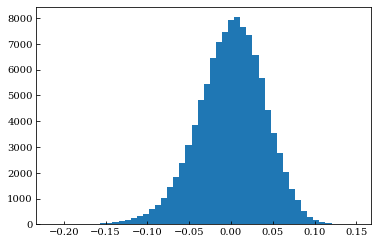

In [9]:
plt.hist(error,50)
dress

## Training with the optimized pipeline

In [10]:
!rm -rf /tmp/PiNet_QM9_pipeline
params = {'model_dir': '/tmp/PiNet_QM9_pipeline',
          'network': {
              'name': 'PiNet',
              'params': {
                  'atom_types':[1, 6, 7, 8, 9],
              },
          },
          'model': {
              'name': 'potential_model',
              'params': {
                  'learning_rate': 1e-3, # Relatively large learning rate
                  'e_scale': 627.5, # Here we scale the model to kcal/mol
                  'e_dress': dress
              }
          }
         }

# The logging behavior of estimator can be controlled here
config = tf.estimator.RunConfig(log_step_count_steps=500)

# Preprocessing the datasets
model = get_model(params, config=config)
network = get_network(model.params['network'])
train = lambda: dataset()['train'].apply(sparse_batch(100)).map(network.preprocess).cache().repeat().shuffle(100)
test = lambda: dataset()['test'].apply(sparse_batch(100))

# Running specs
train_spec = tf.estimator.TrainSpec(input_fn=train, max_steps=1e4)
eval_spec = tf.estimator.EvalSpec(input_fn=test, steps=100)

INFO:tensorflow:Using config: {'_model_dir': '/tmp/PiNet_QM9_pipeline', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 500, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [11]:
tf.estimator.train_and_evaluate(model, train_spec, eval_spec)

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
12112 trainable vaiabless, training with float32 precision.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/PiNet_QM9_pipeline/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after 

({'METRICS/E_LOSS': 119.6964,
  'METRICS/E_MAE': 7.947343,
  'METRICS/E_RMSE': 10.940587,
  'loss': 119.6964,
  'global_step': 10000},
 [])

## Monitoring
It's recommended to monitor the training with Tensorboard instead of the stdout here.  
Try `tensorboard --logdir /tmp`


## Parallelization with tf.Estimator

The estimator api makes it extremely easy to train on multiple GPUs.

In [12]:
# suppose you have two cards
distribution = tf.distribute.MirroredStrategy(2)
config = tf.estimator.RunConfig(train_distribute=distribution)

TypeError: 'int' object is not iterable

## Conclusions

Congratulations! You can now train atomic neural networks with 
state-of-the-art accuracy and speed.


But there's more. With PiNN, the components of ANNs are modulized.
Read the following notebooks to see how you can build your own ANN. 